In [78]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [24]:
def rotate_image(image, angle, interpolation=cv2.INTER_LINEAR):
    """
    Rotates the given image by the specified angle in degrees and returns the rotated image.

    Args:
    - image: a numpy array representing the input image
    - angle: a float representing the rotation angle in degrees
    - interpolation: an optional interpolation method (cv2.INTER_LINEAR by default)

    Returns:
    - a numpy array representing the rotated image
    """
    # Get image size and center point
    height, width = image.shape[:2]
    center = (width / 2, height / 2)

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=interpolation)

    return rotated_image


In [25]:
# 2) Feature detection and description
def read_folder(folder_path="Dataset"):
    """
    Reads all image files in a specified folder.

    Args:
    - folder_path: a string representing the path to the folder containing the images

    Returns:
    - image_paths: a list of strings representing the paths to the images
    """
    # Initialize list for storing image paths
    image_paths = []

    # Loop through all image files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is an image
        if file_name.endswith(".jpg") or file_name.endswith(".jpeg") or file_name.endswith(".png"):
            # Read the image
            image_path = os.path.join(folder_path, file_name)

            # Add the image path to the list
            image_paths.append(image_path)

    return image_paths

In [26]:
def FeatureExtractor(image_paths):
    """
    Extracts features from a list of images.

    Args:
    - image_paths: a list of strings representing the paths to the images

    Returns:
    - features_dict: a dictionary with the image path as the key and another dictionary as the value
                     with the keypoints and descriptors as the keys.
    """
    # Initialize feature extractor
    feature_extractor = cv2.SIFT_create()

    # Initialize dictionary for storing features
    features_dict = {}

    # Loop through all images
    for image_path in image_paths:
        # Read the image
        image = cv2.imread(image_path)

        # Extract features from the image
        keypoints, descriptors = feature_extractor.detectAndCompute(image, None)

        # Add the features to the dictionary
        features_dict[image_path] = {
            "keypoints": keypoints,
            "descriptors": descriptors
        }

    return features_dict

In [57]:
# The goal of feature matching is to find correspondences between keypoints in different images,
# i.e. to determine which keypoints in one image correspond to which keypoints in the other image.
def FeatureMatcher(features_dict, image_pairs):
    # Initialize the feature matcher
    matcher = cv2.BFMatcher()

    # Initialize a dictionary for storing the matches
    matches_dict = {}

    # Loop through all reference images
    for ref_image_path in image_pairs.keys():
        # Get the transformed image paths for the current reference image
        transformed_image_paths = image_pairs[ref_image_path]

        # Get the features for the reference image
        ref_features = features_dict[ref_image_path]

        # Loop through all transformed images for the current reference image
        for transformed_image_path in transformed_image_paths:
            
            # Get the features for the transformed image
            transformed_features = features_dict[transformed_image_path]
            
            # Each element in the list "matches" represents a match between a keypoint in the reference image and a keypoint in the transformed image. 
            # Each DMatch object contains the following attributes:
            # queryIdx: index of the keypoint in the transformed image descriptors
            # trainIdx: index of the keypoint in the reference image descriptors
            # distance: distance between the descriptors of the two keypoints

            # Match the features between the reference and transformed images
            matches = matcher.match(ref_features["descriptors"], transformed_features["descriptors"])

            # Sort the matches by distance
            matches = sorted(matches, key=lambda x: x.distance)

            # Add the matches to the dictionary
            matches_dict[(ref_image_path, transformed_image_path)] = matches

    return matches_dict

In [76]:
def display_matched_keypoints(matches_between_reference_imgs_and_tranformed_imgs, features_dict):
    """
    Display the top ten matched keypoints for each pair of matched reference and transformed images.
    
    Parameters:
        matches_between_reference_imgs_and_tranformed_imgs (dict): A dictionary where the keys are tuples of file paths 
            for matched reference and transformed images, and the values are the corresponding matches between their keypoints.
        
        features_dict (dict): A dictionary where the keys are file paths of images, and the values are the corresponding
            keypoints and descriptors of those images.
    """
    for image_paths, matches in matches_between_reference_imgs_and_tranformed_imgs.items():
        # Read the reference image
        ref_img = cv2.imread(image_paths[0])

        # Read the transformed image
        trans_img = cv2.imread(image_paths[1])

        # Display top ten matched keypoints
        ref_img_matches = cv2.drawMatches(
            ref_img, 
            features_dict[image_paths[0]]["keypoints"], 
            trans_img, 
            features_dict[image_paths[1]]["keypoints"], 
            matches[:10], 
            None
        )
        cv2.imshow("Top 10 matched keypoints", ref_img_matches)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [84]:
def plot_matching_distance(matches, title):
    """
    Plot the matching distance for the top 100 matched key points.
    
    Parameters:
        matches (list): A list of matches between keypoints.
    """
    # Extract the matching distances for the top 100 matched key points
    distances = [match.distance for match in matches[:100]]

    # Extract the indices of the top 100 matched key points
    keypoint_indices = [match.queryIdx for match in matches[:100]]

    # Plot the matching distances with the keypoint indices on the x-axis
    plt.plot(keypoint_indices, distances)
    plt.xlabel("Keypoint Indices")
    plt.ylabel("Matching Distance")
    plt.title(title)
    plt.show()


In [90]:
# this function will be used to find what is the effect of increasing the scale or the rotation on the matching distance
def sum_matching_distances(matches1, matches2):
    """
    Compute the sum of matching distances between pairs of keypoints in two lists of DMatch objects.

    Parameters:
        matches1 (list): A list of DMatch objects.
        matches2 (list): Another list of DMatch objects.

    Returns:
        float: The sum of matching distances between the matched keypoints in the two lists of DMatch objects.
    """
    # Make sure the lists have the same length
    if len(matches1) != len(matches2):
        raise ValueError("Input lists must have the same length")

    # Compute the sum of difference between matching distances between the pairs of keypoints
    # if the total_distance ends up being a very small value then we can assume that the rotation
    # or scaling didn't affect the distances between the matching keypoints much. However, if it is large
    # it means the affect was considerable
    total_distance = sum(match1.distance - match2.distance for match1, match2 in zip(matches1, matches2))

    return total_distance


In [27]:
# 1) Create your own dataset

# Load the reference images
ref_image1 = cv2.imread('Dataset/reference_1.jpg')
ref_image2 = cv2.imread('Dataset/reference_2.jpg')

# image scaling using bicubic interpolation to generate new reference images at different scales
# Scale the reference images by a factor of 2
transformed1_S2 = cv2.resize(ref_image1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
transformed2_S2 = cv2.resize(ref_image2, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Scale the reference images by a factor of 5
transformed1_S5 = cv2.resize(ref_image1, None, fx=5, fy=5, interpolation=cv2.INTER_CUBIC)
transformed2_S5 = cv2.resize(ref_image2, None, fx=5, fy=5, interpolation=cv2.INTER_CUBIC)

# Save the transformed images with the desired names
cv2.imwrite('Dataset/transformed1_S2.jpg', transformed1_S2)
cv2.imwrite('Dataset/transformed1_S5.jpg', transformed1_S5)
cv2.imwrite('Dataset/transformed2_S2.jpg', transformed2_S2)
cv2.imwrite('Dataset/transformed2_S5.jpg', transformed2_S5)


# Rotate reference images by the defined angles to create transformed images
transformed1_R30 = rotate_image(ref_image1, 30)
transformed1_R130 = rotate_image(ref_image1, 150)
transformed2_R30 = rotate_image(ref_image2, 30)
transformed2_R130 = rotate_image(ref_image2, 150)

# Display the rotated images (optional)
show = False
if show:
    cv2.imshow("Rotated image 1 (30 degrees)", transformed1_R30)
    cv2.imshow("Rotated image 1 (150 degrees)", transformed1_R130)
    cv2.imshow("Rotated image 2 (30 degrees)", transformed2_R30)
    cv2.imshow("Rotated image 2 (150 degrees)", transformed2_R130)
    cv2.waitKey(0)

# Save the transformed images in the "Dataset" folder
cv2.imwrite('Dataset/transformed1_R30.jpg', transformed1_R30)
cv2.imwrite('Dataset/transformed1_R130.jpg', transformed1_R130)
cv2.imwrite('Dataset/transformed2_R30.jpg', transformed2_R30)
cv2.imwrite('Dataset/transformed2_R130.jpg', transformed2_R130)



True

In [48]:
# Read the folder
image_paths = read_folder("Dataset")

# Extract features from the images
features_dict = FeatureExtractor(image_paths)

In [56]:
# The reason why each keypoint in SIFT is represented by a descriptor of 128 elements 
# is because it provides a good balance between accuracy and efficiency. The descriptor 
# is essentially a vector that encodes information about the local image gradient orientations 
# and magnitudes around the keypoint.

# this is how features_dict looks like:
# my_dict = {
#    "image1.jpg": {
#        "keypoints": [...],
#        "descriptors": [...]
#    },
#    "image2.jpg": {
#        "keypoints": [...],
#        "descriptors": [...]
#    }, etc
# }
print(type(features_dict))

num_images = len(features_dict)  # get the number of images
print("Number of images:", num_images)

for image_path, img_features in features_dict.items():
    num_keypoints = len(img_features["keypoints"])
    print("Image:", image_path, "has", num_keypoints, "keypoints.")
    

<class 'dict'>
Number of images: 10
Image: Dataset\reference_1.jpg has 4446 keypoints.
Image: Dataset\reference_2.jpg has 1976 keypoints.
Image: Dataset\transformed1_R130.jpg has 4708 keypoints.
Image: Dataset\transformed1_R30.jpg has 4798 keypoints.
Image: Dataset\transformed1_S2.jpg has 10910 keypoints.
Image: Dataset\transformed1_S5.jpg has 10711 keypoints.
Image: Dataset\transformed2_R130.jpg has 1747 keypoints.
Image: Dataset\transformed2_R30.jpg has 1727 keypoints.
Image: Dataset\transformed2_S2.jpg has 2901 keypoints.
Image: Dataset\transformed2_S5.jpg has 2836 keypoints.


In [59]:
image_dict = {
    "Dataset\\reference_1.jpg": ["Dataset\\transformed1_R130.jpg", "Dataset\\transformed1_R30.jpg", "Dataset\\transformed1_S2.jpg", "Dataset\\transformed1_S5.jpg"],
    "Dataset\\reference_2.jpg": ["Dataset\\transformed2_R130.jpg", "Dataset\\transformed2_R30.jpg", "Dataset\\transformed2_S2.jpg", "Dataset\\transformed2_S5.jpg"]
}

In [60]:
matches_between_reference_imgs_and_tranformed_imgs = FeatureMatcher(features_dict, image_dict)

In [73]:
print(type(matches_between_reference_imgs_and_tranformed_imgs))
# it is 8 because we have 2 reference images and per reference image we have 4 transformed images.
# so, in total there are 8 comparisons
print((matches_between_reference_imgs_and_tranformed_imgs.keys()))

<class 'dict'>
dict_keys([('Dataset\\reference_1.jpg', 'Dataset\\transformed1_R130.jpg'), ('Dataset\\reference_1.jpg', 'Dataset\\transformed1_R30.jpg'), ('Dataset\\reference_1.jpg', 'Dataset\\transformed1_S2.jpg'), ('Dataset\\reference_1.jpg', 'Dataset\\transformed1_S5.jpg'), ('Dataset\\reference_2.jpg', 'Dataset\\transformed2_R130.jpg'), ('Dataset\\reference_2.jpg', 'Dataset\\transformed2_R30.jpg'), ('Dataset\\reference_2.jpg', 'Dataset\\transformed2_S2.jpg'), ('Dataset\\reference_2.jpg', 'Dataset\\transformed2_S5.jpg')])


In [96]:
display_matched_keypoints(matches_between_reference_imgs_and_tranformed_imgs, features_dict)

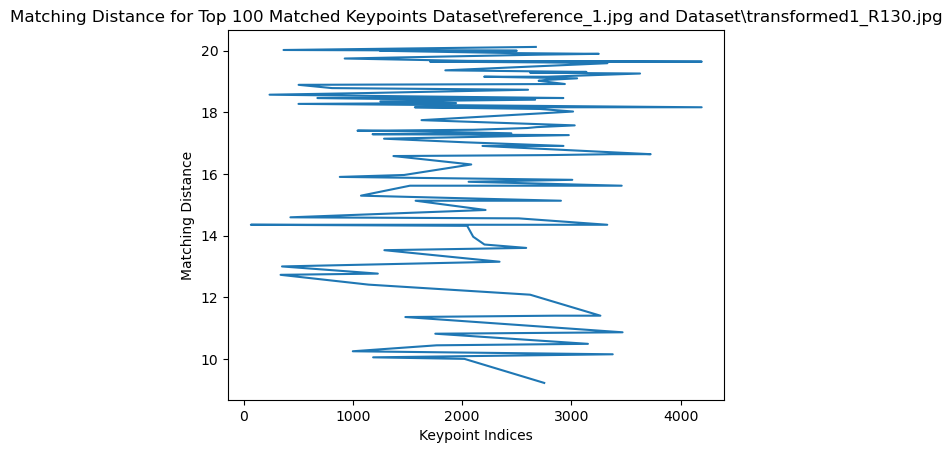

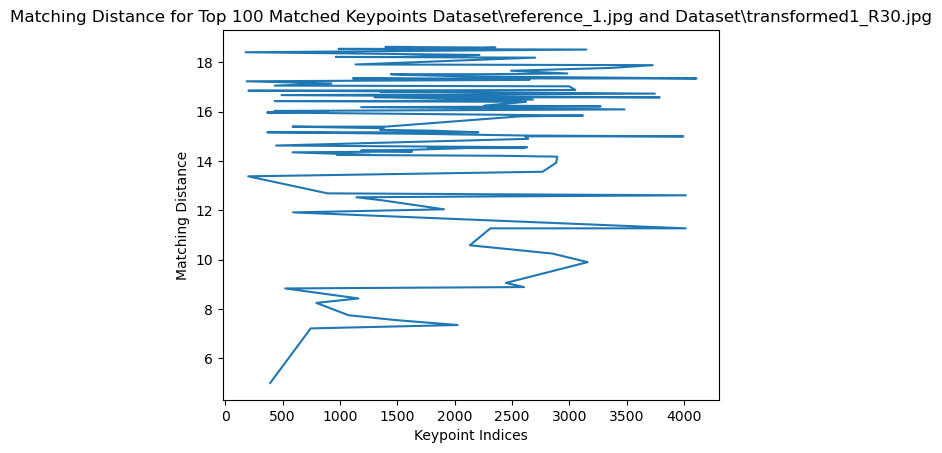

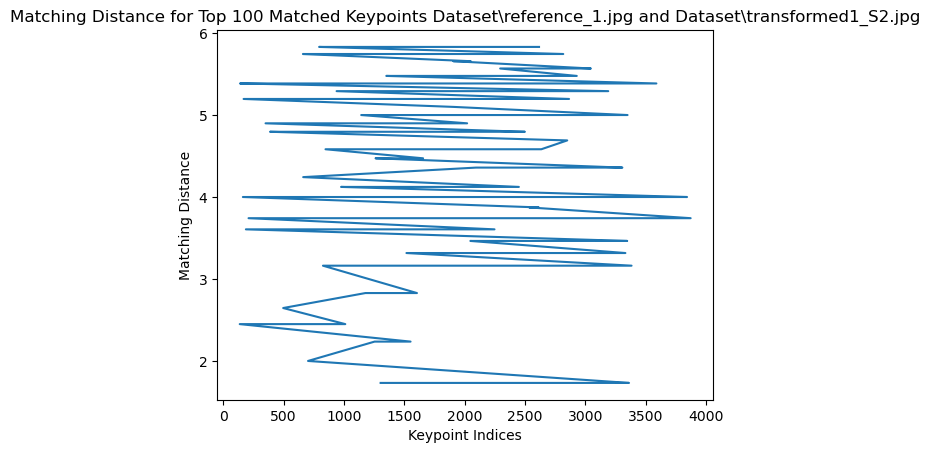

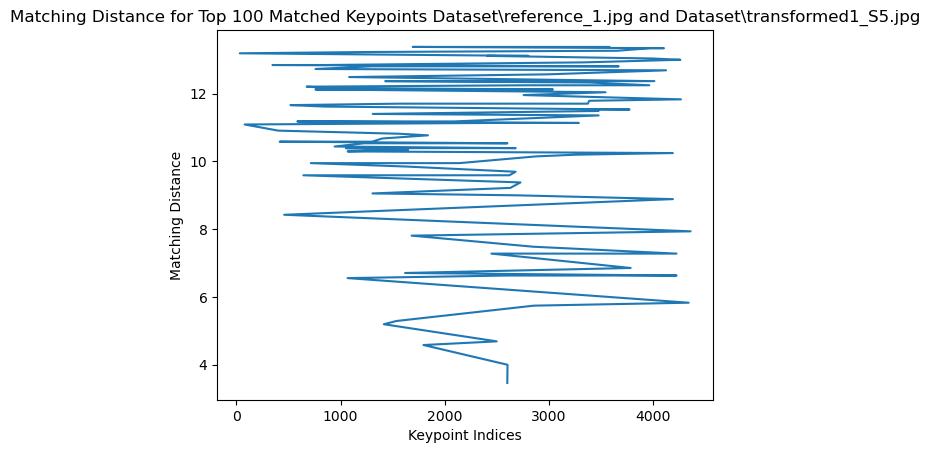

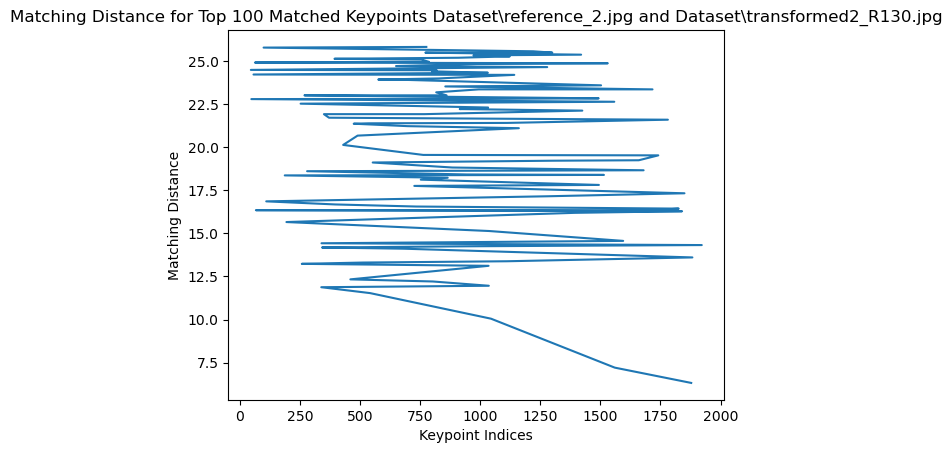

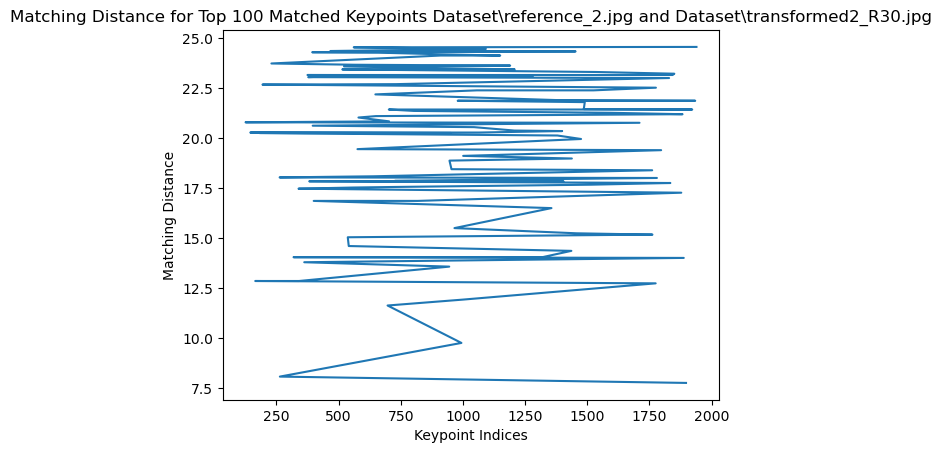

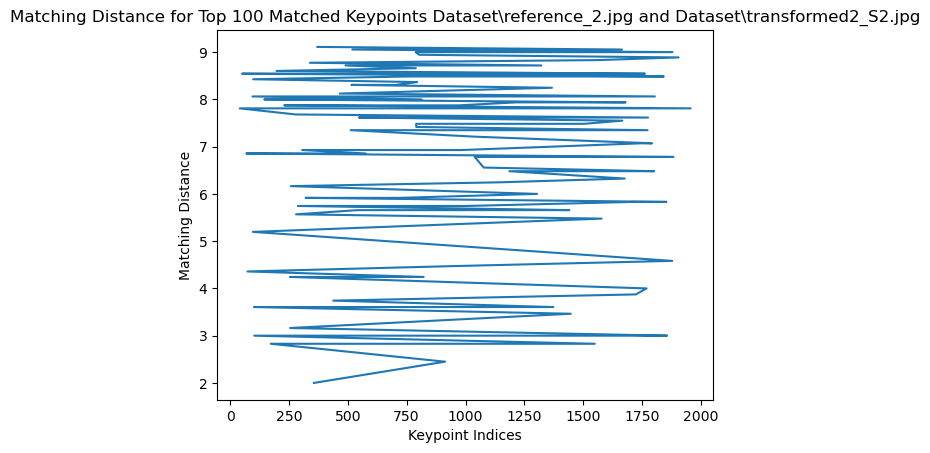

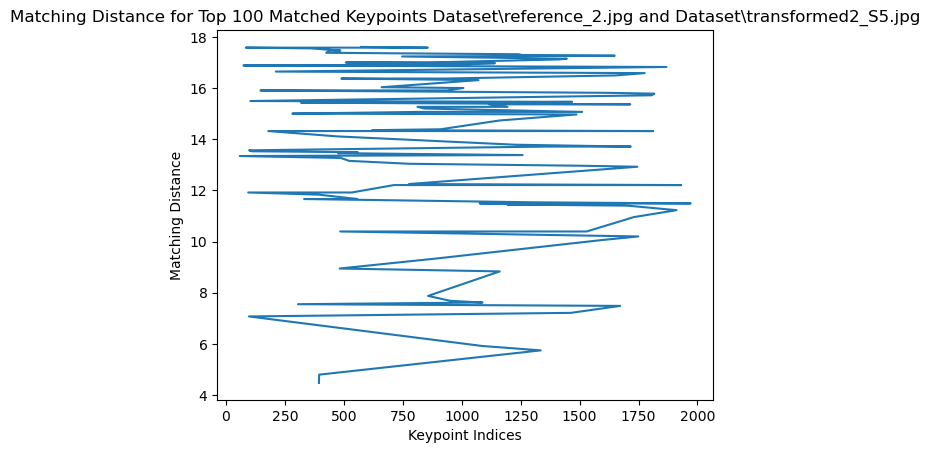

In [88]:
# Loop through the values of a dictionary containing matches between keypoints,
# and call the plot_matching_distance() function for each match.

for imgs, matches in matches_between_reference_imgs_and_tranformed_imgs.items():
    plot_matching_distance(matches, "Matching Distance for Top 100 Matched Keypoints " + imgs[0] + " and " + imgs[1])

In [95]:
# In SIFT, the matching distances are computed generally as the Euclidean distance between the 128-dimensional 
# feature vectors that are based on the gradient magnitudes and orientations in a 16x16 neighborhood around the 
# keypoint of the keypoints. The descriptor is computed based on the gradient magnitudes and orientations in a 
# 16x16 pixel neighborhood around the keypoint, hence SIFT is able to capture local image information that is 
# invariant to scale, rotation, and partial occlusion. 

# Nevertheless, the degree of rotation and scale does affect the distances between the matching keypoints. 
# If the image is rotated by a small degree, the gradient orientations of the pixels in the rotated image will 
# change only slightly, and the SIFT descriptors computed at the keypoints will also change only slightly. 
# This means that the matching distances between the keypoints in the original image and the rotated image will 
# not be significantly affected by small rotations. However, if the image is rotated by a large degree, the gradient
# orientations and magnitudes of the pixels in the rotated image will change significantly, which will in turn affect
# the SIFT descriptors computed at the keypoints. The descriptors may no longer match as closely, which can result in 
# higher matching distances between keypoints in the original image and the rotated image. In general, the effect of 
# rotation on the matching distance between keypoints depends on the degree of rotation and the specific image content. 
# Small rotations may not have a significant effect, but large rotations can cause significant changes in the gradient
# orientations and magnitudes, which can affect the SIFT descriptors and the matching distances between keypoints.
# For that reason, a rotation of 30 degrees results in lower distances between matching keypoints when compared to 150 
# degrees of rotation that results in larger distances between matching keypoints. 

for i, (imgs1, matches1) in enumerate(matches_between_reference_imgs_and_tranformed_imgs.items()):
    
    if (i%2 == 1):
        continue
        
    # Skip the last element if the length of the dictionary is odd
    if i == len(matches_between_reference_imgs_and_tranformed_imgs) - 1 and len(matches_between_reference_imgs_and_tranformed_imgs) % 2 == 1:
        continue

    # Get the key-value pair of the next element in the dictionary
    imgs2, matches2 = list(matches_between_reference_imgs_and_tranformed_imgs.items())[i+1]

    distance = sum_matching_distances(matches1, matches2)
    print(imgs1, " and ", imgs2,  " has difference in distance: ", distance)
    
    
# The result we get is actually understandable. First, for reference_1 image, there are several components in the image
# that have comparable sizes to each other. Hence, when we rotate by 150 the distances of the keypoints to the original image
# are larger when compared to a rotation of 30 degrees. Similar argument goes for scaling: scaling more increase the distance between
# matching keypoints more significantly. However, reference_2 shows an interesting characteristic. Rotating more or scaling more 
# brings the keypoints between the original image and the transformed images closer together when compared to low values. That 
# might be because in reference_2 there is a large umbrella in the image and a rotation of 150 degrees can actually bring the 
# umbrella to a position such that the matching keypoints become closer. As it can be seen, a generalization can't be made
# with huge certainty. Even though we can say that generally lesser rotation/scaling results in lower distances between
# corresponding keypoints, however, that isn't always the case because the structure of the image can also play a role in 
# how rotation/scaling affects the respective position of corresponding keypoints.


('Dataset\\reference_1.jpg', 'Dataset\\transformed1_R130.jpg')  and  ('Dataset\\reference_1.jpg', 'Dataset\\transformed1_R30.jpg')  has difference in distance:  15546.380850315094
('Dataset\\reference_1.jpg', 'Dataset\\transformed1_S2.jpg')  and  ('Dataset\\reference_1.jpg', 'Dataset\\transformed1_S5.jpg')  has difference in distance:  -37777.928114414215
('Dataset\\reference_2.jpg', 'Dataset\\transformed2_R130.jpg')  and  ('Dataset\\reference_2.jpg', 'Dataset\\transformed2_R30.jpg')  has difference in distance:  -8296.925999641418
('Dataset\\reference_2.jpg', 'Dataset\\transformed2_S2.jpg')  and  ('Dataset\\reference_2.jpg', 'Dataset\\transformed2_S5.jpg')  has difference in distance:  -41626.49773955345
